# Exploritory Look into Design Pattern Lifespan

Using the Ignite project for initial exploration: https://github.com/apache/ignite

We'll be using Pinot for detecting design patterns: https://www.cs.ucdavis.edu/~shini/research/pinot/

In [1]:
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
from analysis_tools import *
server_docs = get_sorted_documents('topo-order')

In [2]:
num_patterns = []
files = []
diffs =[]
modified_files = []
documents = []
for document in server_docs:
    if document['merge']:
        num_patterns.append(document['summary'])
        #diffs.append(document['z'])
        files.append(document['files'])
        modified_files.append(document['modified_files'])
        documents.append(document)

## Pattern multiplicity 

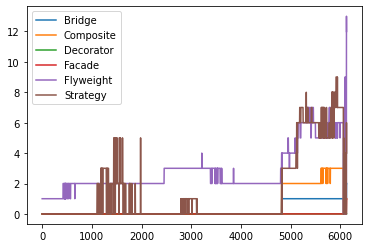

None

{'Abstract Factory': 0, 'Factory Method': 0, 'Singleton': 0, 'Adapter': 0, 'Bridge': 2, 'Composite': 1, 'Decorator': 0, 'Facade': 1, 'Flyweight': 12, 'Proxy': 0, 'Chain of Responsibility': 0, 'Mediator': 0, 'Observer': 0, 'State': 0, 'Strategy': 4, 'Template Method': 0, 'Visitor': 0}


In [3]:
plt.plot([x['Bridge'] if 'Bridge'in x else 0 for x in num_patterns], label='Bridge')
plt.plot([x['Composite'] if 'Composite'in x else 0 for x in num_patterns], label='Composite')
plt.plot([x['Decorator'] if 'Decorator'in x else 0 for x in num_patterns], label='Decorator')
plt.plot([x['Facade'] if 'Facade'in x else 0 for x in num_patterns], label='Facade')
plt.plot([x['Flyweight'] if 'Flyweight'in x else 0 for x in num_patterns], label='Flyweight')
plt.plot([x['Strategy'] if 'Strategy'in x else 0 for x in num_patterns], label='Strategy')
plt.legend()
display(plt.show())
print(num_patterns[-1])

We can see that the tool we're using doesn't detect a ton of design patterns. Some patterns which we can find by hand like factory or singleton are not present. 

When we run the tool we can see that it only processes 300 class files out of the 6000+ files in the code so something is definitely wrong with the processing. Need to validate that findings are true as opposed to a byproduct of the tool. 

One suggestion was to use two tools and try to find the intersection between them. 

## Pattern Lifespan

In [4]:
from lifecycle_parser import LifecycleParser

parser = LifecycleParser(server_docs)
for title in ['Flyweight', 'Strategy', 'Bridge']: 
    display(parser.pattern_timeline(title))

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

[]

In [6]:
for x in parser.get_detected_patterns('Flyweight'): 
    display(parser.git_pattern_instance_timeline(x, 'Flyweight'))

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

KeyboardInterrupt: 

**Brief Description** 

The y axis denotes the different instances of the deisgn patern. The names of the files involved are concatanated together. The x axis denotes the commit number. 

**Observations** 

We can see that there are a large number of design patterns that fade in and out at the beginning and/or end of a patterns life cycle. We also see a number of design patterns that stay around for a short while, or only exist for a single commit. We also don't see many design patterns that exist for a long period of time. We see one flyweight that exists the entire project (it get's renamed part way through). We also don't see large gaps in between design patterns. 

## Validation

Check to see if changes from one state to another only involve the modified files.

In [10]:
def getFileNames(file_list): 
    return [str(x).split('/')[-1].replace('.java', '') for x in file_list]
flaky_interval = {}
success = 0
fail = 0
for key, value in pattern_intervals.items():
    flaky_interval[key] = []
    for interval in value: 
        pattern_files = interval['instance'].split('-')
        start_success = False
        end_success = False
        for file in pattern_files: 
            if file in getFileNames(modified_files[interval['start']]):
                start_success = True
            if file in getFileNames(modified_files[interval['end']]):
                    end_success = True
        if not start_success:
            fail += 1
        else: 
            success+= 1
        if not start_success and not end_success:
            interval['color'] = 'flaky'
        elif not start_success or not end_success: 
            interval['color'] = 'semi flaky'
        else: 
            interval['color'] = 'correct'
        flaky_interval[key].append(interval)

print('Source Modification + DP detection:', success)
print('No Source Modification + DP Detection:', fail)
                
for key, value in flaky_interval.items(): 
    source = pd.DataFrame(value)
    display(alt.Chart(source).mark_bar().encode(
        x='start',
        x2='end',
        y='instance',
        color='color'
    ).properties(title=key))

NameError: name 'pattern_intervals' is not defined

# Including Git Information

## Git Ordering
During validation we've realized that the order of commits can cause many of these patterns to come in and out. The product after a merge will usually include the pattern but the lead up may have interspersed commits. The best sorting method to limit this is using topo-sort which tries to group commits from the same branch together. 

For example let's take a look at the first instance of misalignment. The number of files changed are: 

In [6]:
documents[672]['files']

2

However the differnece in the number of files are larger then this difference: 

In [7]:
print('Num Files in Previous Commit:', len(get_files_at_commit(documents[671]['_id'])))
print('Num Files in Target Commit:', len(get_files_at_commit(documents[672]['_id'])))

Num Files in Previous Commit: 2165
Num Files in Target Commit: 2165


Additionally we can see that the file we're looking for isn't available in the previous commit. 

In [8]:
'../ignite/modules/core/src/test/java/org/gridgain/grid/util/ipc/shmem/benchmark/GridIpcSharedMemoryBenchmarkParty.java' in get_files_at_commit(documents[671]['_id'])

True

## Manual Validation

Manually check if the Pinot tool is giving us artifacts that are actual design patterns. We'll use a script `manual_pattern_check.py` to go through a random point in a pattern and check if it holds up with the GoF pattern. 

To help us we will prepare the data we've aggregated here to iterate through. 

In [7]:
import json as json_helper

def index_to_hash(interval): 
    return {'start': documents[interval['start']]['_id'], 'end': documents[interval['end']]['_id']}

json = {}
for pattern, intervals in pattern_intervals.items(): 
    dp_instance = {}
    for interval in intervals: 
        if not interval['instance'] in dp_instance: 
            dp_instance[interval['instance']] = [index_to_hash(interval)]
        else: 
            dp_instance[interval['instance']].append(index_to_hash(interval))
    json[pattern] = dp_instance
    
with open('pattern_intervals.json', 'w') as fp: 
    json_helper.dump(json, fp)

NameError: name 'pattern_intervals' is not defined

In [8]:

pattern_validation = {}
with open('./pattern_validation.json', 'r') as f: 
    pattern_validation = json_helper.load(f)

print('Number of Accurate finds:')
print(str(sum([value for key, value in pattern_validation.items()])) + '/' + str(len(pattern_validation)))

Number of Accurate finds:
58/70


In [9]:
items = []
for pattern, dp_instances in json.items():
    for dp in dp_instances: 
        color = 'Undefined'
        if dp in pattern_validation: 
            color = 'Correct' if pattern_validation[dp] else 'Incorrect'
        items.append({'count': 1, 'pattern': pattern, 'Validation': color})
        
source = pd.DataFrame(items)
display(alt.Chart(source).mark_bar().encode(
    x='count',
    y='pattern',
    color='Validation'
).properties(title='Pattern Manual Validation'))

ValueError: Validation encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

alt.Chart(...)

The Pinot tool is quite accurate at recognizing design patterns, however there are some confusing instances where it is unclear whether it is appropriate to claim that the tool is right. For example `IndexQueryCriteriaBuilder` was classified as a Facade design pattern when it also satisfies the Builder design pattern. 

## Sorting Interruptions 

Now that we know that Git ordering contributes largely to the interruptions we see in our lifecycle graphs, let's sort through those and look into situations where: 
- The change in number of files is proportional to the number of files present 
- The related files exist in both commits 
- Pinot no longer detected the design pattern 

In [12]:
interruptions = {}

def isInterruptionAuthentic(currentIndex, nextIndex, dp_files): 
    if len(documents) < currentIndex < 0 or len(documents) < nextIndex < 0 : 
        return False
    currentDocument = documents[currentIndex]
    nextDocument = documents[nextIndex]
    
    currentFiles = getFileNames(get_files_at_commit(currentDocument['_id']))
    nextFiles = getFileNames(get_files_at_commit(nextDocument['_id']))
    if nextDocument['files'] != len(nextFiles) - len(currentFiles): 
        return False
    
    for file in dp_files: 
        if file in currentFiles and file in nextFiles: 
            return True
    return False

for key, value in pattern_intervals.items():
    interruptions[key] = []
    for interval in value: 
        pattern_files = interval['instance'].split('-')
        if isInterruptionAuthentic(interval['start'] - 1, interval['start'], pattern_files):
            interruption = index_to_hash({'start': interval['start']-1, 'end':interval['start']})
            interruption['instance'] = interval['instance']
            interruptions[key].append(interruption)
            
        if isInterruptionAuthentic(interval['end'], interval['end'] + 1, pattern_files):
            interruption = index_to_hash({'start': interval['end']-1, 'end':interval['end']})
            interruption['instance'] = interval['instance']
            interruptions[key].append(interruption)
            


In [13]:
def getFileNames(file_list): 
    return [str(x).split('/')[-1].replace('.java', '') for x in file_list]
flaky_interval = {}
success = 0
fail = 0
for key, value in pattern_intervals.items():
    flaky_interval[key] = []
    for interval in value: 
        pattern_files = interval['instance'].split('-')
        start_success = False
        end_success = False
        for file in pattern_files: 
            if file in getFileNames(modified_files[interval['start']]):
                start_success = True
            if file in getFileNames(modified_files[interval['end']]):
                    end_success = True
        if not start_success:
            fail += 1
        else: 
            success+= 1
        if not interval['instance'] in pattern_validation:
            interval['color'] = 'undefined'
        elif pattern_validation[interval['instance']]: 
            interval['color'] = 'Correct'
        else: 
            interval['color'] = 'incorrect'
        flaky_interval[key].append(interval)

                
for key, value in flaky_interval.items(): 
    source = pd.DataFrame(value)
    display(alt.Chart(source).mark_bar().encode(
        x='start',
        x2='end',
        y='instance',
        color='color'
    ).properties(title=key))

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)